In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
fireballs = pd.read_csv('fireballs-data.csv')
fireballs.head(10)

,previous_position,player_position,density_col_0,density_col_1,density_col_2,density_col_3,density_col_4,density_col_5,ETA_nearest,offset_from_nearest,safe_zone_width,edge_awareness,final_position
0,2,1,1,0,1,1,0,0,380.28,-169.72,3,1,1
1,1,2,1,1,0,4,0,0,147.83,-402.17,0,2,2
2,2,1,1,0,1,4,0,0,125.72,-424.28,0,1,1
3,1,0,0,1,2,3,0,0,369.05,-180.95,0,0,0
4,0,1,4,0,2,0,0,0,126.61,-423.39,0,1,1
5,1,2,3,1,1,1,0,0,239.93,-310.07,0,2,2
6,2,3,2,2,1,1,0,0,263.35,-286.65,0,2,3
7,3,4,1,2,1,1,1,0,331.36,-218.64,0,1,4
8,4,3,0,1,1,1,2,1,184.86,-365.14,0,2,3
9,3,2,0,0,0,2,2,2,181.89,-368.11,0,2,2


In [3]:
fireballs['safe_zone_width'].value_counts()

safe_zone_width
0    187
1      7
2      3
3      2
4      1
Name: count, dtype: int64

In [4]:
fireballs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   previous_position    200 non-null    int64  
 1   player_position      200 non-null    int64  
 2   density_col_0        200 non-null    int64  
 3   density_col_1        200 non-null    int64  
 4   density_col_2        200 non-null    int64  
 5   density_col_3        200 non-null    int64  
 6   density_col_4        200 non-null    int64  
 7   density_col_5        200 non-null    int64  
 8   ETA_nearest          200 non-null    float64
 9   offset_from_nearest  200 non-null    float64
 10  safe_zone_width      200 non-null    int64  
 11  edge_awareness       200 non-null    int64  
 12  final_position       200 non-null    int64  
dtypes: float64(2), int64(11)
memory usage: 20.4 KB


## Feature Engineering

In [5]:
# creating a feature to check if the fireball is in the same column as the player
def check_threat(row):
    col = int(row['player_position'])
    return row[f'density_col_{col}']
fireballs['is_in_danger'] = fireballs.apply(check_threat, axis = 1)


In [6]:
# creating a feature to know the density of fireballs on the left and right of the player
def left_dens(row):
    col = int(row['player_position'])
    if col > 0:
        return row[f'density_col_{col-1}']
    else:
        return 99
fireballs['left_density'] = fireballs.apply(left_dens, axis = 1)

def right_dens(row):
    col = int(row['player_position'])
    if col < 5:
        return row[f'density_col_{col+1}']
    else:
        return 99
fireballs['right_density'] = fireballs.apply(right_dens, axis = 1)

In [7]:
# creating boolean features to check if it safe to move right
def is_left_saf(row):
    col = int(row['player_position'])
    if col > 0:
        return 1 if row[f'density_col_{col-1}'] == 0 else 0
    else:
        return 0
fireballs['is_left_safe'] = fireballs.apply(is_left_saf, axis = 1)

# creating boolean features to check if it is safe to move right
def is_right_saf(row):
    col = int(row['player_position'])
    if col < 5:
        return 1 if row[f'density_col_{col+1}'] == 0 else 0
    else:
        return 0
fireballs['is_right_safe'] = fireballs.apply(is_right_saf, axis = 1)

In [8]:
def closest_safe_col(row):
    col = int(row['player_position'])
    
    # Check if the left and right columns are safe
    left_safe = col > 0 and row[f'density_col_{col - 1}'] == 0  # Left column is safe if player isn't at position 0 and no fireball
    right_safe = col < 5 and row[f'density_col_{col + 1}'] == 0  # Right column is safe if player isn't at position 5 and no fireball
    
    # If both columns are safe, choose the closest one
    if left_safe and right_safe:
        # Choose the closer column
        return col - 1 if col - 1 >= 0 else col + 1
    
    # If only one of the columns is safe, choose that one
    if left_safe:
        return col - 1
    if right_safe:
        return col + 1
    
    # If neither is safe, stay in the current position (no safe move)
    return col

def dist_to_safe(row):
    col = int(row['player_position'])
    safe_col = row['closest_safe_col']
    
    # Distance to the closest safe column
    return abs(col - safe_col)

# Apply the functions to create the new features
fireballs['closest_safe_col'] = fireballs.apply(closest_safe_col, axis=1)
fireballs['dist_to_safe'] = fireballs.apply(dist_to_safe, axis=1)


In [9]:
# creating a feature to check if the player is at the edge
def at_edge(row):
    return 1 if row['player_position'] == 0 or row['player_position'] == 5 else 0
fireballs['at_edge'] = fireballs.apply(at_edge, axis=1)

## Data Splitting

In [10]:
selected_features = ['right_density', 'left_density', 'closest_safe_col']
x = fireballs[selected_features]
y = fireballs['final_position']

In [11]:
x.shape

(200, 3)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

base_estimator = DecisionTreeClassifier(max_depth=1)
model = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
model.fit(x_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   random_state=42)

In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.675


In [14]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.54      0.88      0.67         8
           2       0.86      0.55      0.67        11
           3       0.89      0.73      0.80        11
           4       0.55      1.00      0.71         6
           5       0.00      0.00      0.00         2

    accuracy                           0.68        40
   macro avg       0.47      0.52      0.47        40
weighted avg       0.67      0.68      0.64        40



c:\Users\Jakkala\anaconda3\envs\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jakkala\anaconda3\envs\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jakkala\anaconda3\envs\ml-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

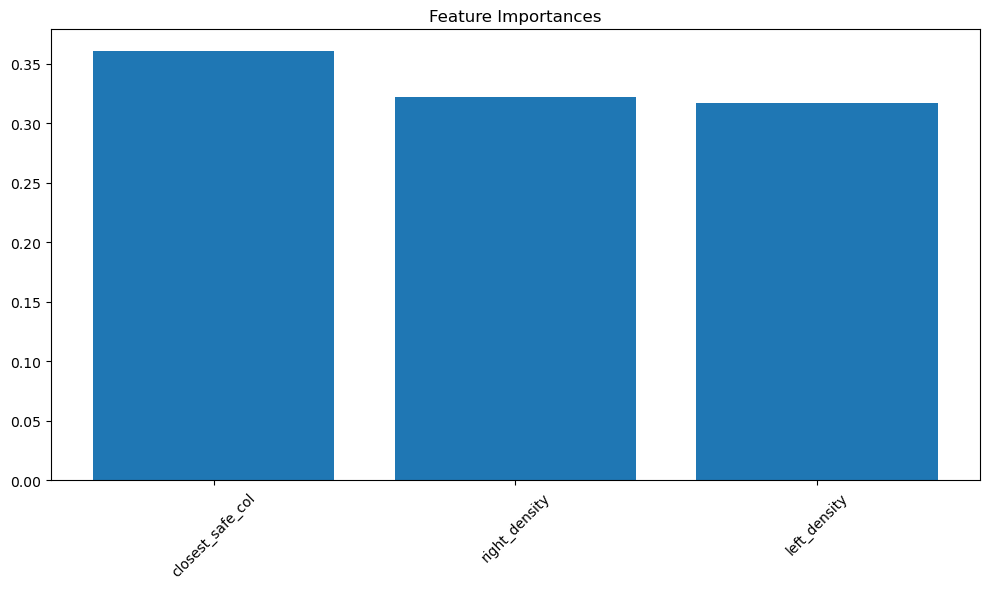

In [15]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = x.columns

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [16]:
import joblib
joblib.dump(model, "adaboost_model.pkl")

['adaboost_model.pkl']

## Creating important features for 'replay-features' data

In [ ]:
records = pd.read_csv('replay-features.csv')
records.head(10)

FileNotFoundError: [Errno 2] No such file or directory: 'fireballs-features.csv'

In [ ]:
records['is_in_danger'] = records.apply(check_threat, axis = 1)
records['left_density'] = records.apply(left_dens, axis = 1)
records['right_density'] = records.apply(right_dens, axis = 1)
records['is_left_safe'] = records.apply(is_left_saf, axis = 1)
records['is_right_safe'] = records.apply(is_right_saf, axis = 1)
records['closest_safe_col'] = records.apply(closest_safe_col, axis=1)
records['dist_to_safe'] = records.apply(dist_to_safe, axis=1)
records['at_edge'] = records.apply(at_edge, axis=1)

In [ ]:
records.columns

Index(['previous_position', 'player_position', 'density_col_0',
       'density_col_1', 'density_col_2', 'density_col_3', 'density_col_4',
       'density_col_5', 'ETA_nearest', 'offset_from_nearest',
       'safe_zone_width', 'edge_awareness', 'final_position', 'is_in_danger',
       'left_density', 'right_density', 'is_left_safe', 'is_right_safe',
       'closest_safe_col', 'dist_to_safe', 'at_edge'],
      dtype='object')

In [ ]:
fireballs.columns

Index(['previous_position', 'player_position', 'density_col_0',
       'density_col_1', 'density_col_2', 'density_col_3', 'density_col_4',
       'density_col_5', 'ETA_nearest', 'offset_from_nearest',
       'safe_zone_width', 'edge_awareness', 'final_position', 'is_in_danger',
       'left_density', 'right_density', 'is_left_safe', 'is_right_safe',
       'closest_safe_col', 'dist_to_safe', 'at_edge'],
      dtype='object')

In [ ]:
prediction_features = records[['right_density', 'left_density', 'closest_safe_col']]

In [ ]:
model.predict(prediction_features)

array([3, 1, 3, 2, 4, 4, 3, 1, 1, 1, 1, 2, 4, 4, 3, 2, 3, 2, 1, 2, 3, 2,
       3, 4, 3])

In [ ]:
model.predict(prediction_features).shape

(25,)